# Ley del semicirculo de Wigner

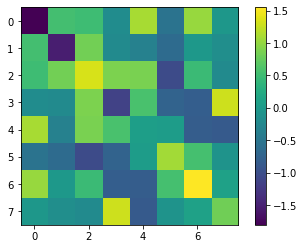

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

#funcion de densidad (semicirculo de Wigner)
def density_func(x,dim):
    return((2/((np.pi)*(2*dim)))*np.sqrt(2*dim-(x**2)))
    
#funcion pa generar la distribucion espectral
def spec_dist(n_sets,dim):
    n_x=[]
    for ii in range(n_sets):
        A = np.random.randn(dim,dim)
        A = (A+np.transpose(A))/2
        for jj in range(dim):
            n_x.append(np.linalg.eigvals(A)[jj])
    return(n_x)

M=np.random.randn(8,8)
plt.imshow((M+np.transpose(M))/2)
plt.colorbar()

# Para muchas matrices pequeñas 


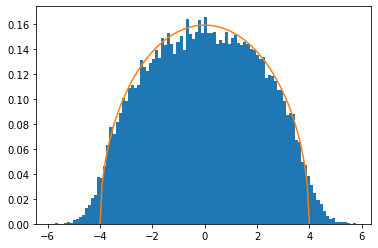

In [2]:
plt.hist(spec_dist(5000,8),100, density=True)
plt.plot(np.linspace(-4,4,100),density_func(np.linspace(-4,4,100),8))

In [3]:
#Se tienen los limites espectrales en:

print([-np.sqrt(2*8),np.sqrt(2*8)])

[-4.0, 4.0]


# Para matrices grandes


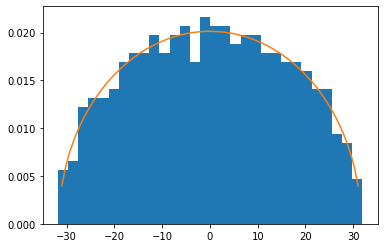

In [4]:
plt.hist(spec_dist(1,500),30,density=True)
plt.plot(np.linspace(-31,31,100),density_func(np.linspace(-31,31,100),500))

In [5]:
#Se tienen los limites espectrales en:

print([-np.sqrt(2*500),np.sqrt(2*500)])

[-31.622776601683793, 31.622776601683793]


# Marchenko-Pastur Density

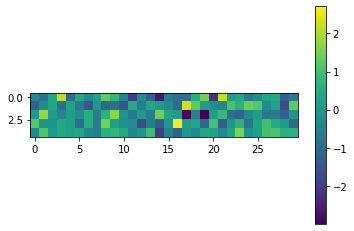

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def cv(a):
    #para definir la matriz de covarianza
    return np.matmul(a, a.transpose())/a.shape[1]

a1=np.random.normal(size=(5,30))

plt.imshow(a1)
plt.colorbar()

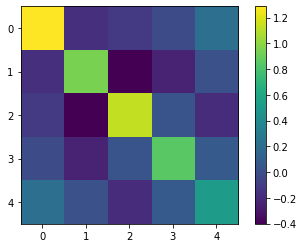

In [2]:
plt.imshow(cv(a1))
plt.colorbar()

In [3]:
#los eigenvalores
ee, ev=np.linalg.eigh(cv(a1))
ee

array([0.42173145, 0.49205787, 0.90254592, 1.41106946, 1.5172061 ])

In [4]:
def marchpast(l, g):
    "Distribucion Marchenko-Pastur"
    def m0(a):
        "Maximo en (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus  = (1+g**0.5)**2
    gminus = (1-g**0.5)**2
    return np.sqrt( m0(gplus-l)*m0(l-gminus) ) / (2*np.pi*g*l)

def randcv(n, p, s):
    """
    funcion para crear varias matrices de covarianza
    s matrices de covarianza creadas con matrices de forma n x p 
    Da un arreglo de dimensiones  s x n x n
    """
    r=[]
    for i in range(s):
        x=np.random.normal(size=(n,p))
        r.append(cv(x))
    return np.array(r)

def EE(a, gamma):
    "Funcion pa los histogramas"
    ee, ev=np.linalg.eigh(a)
    nn, bb, patches=plt.hist(ee.ravel(), 
                                bins="auto", 
                                density=True)
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, gamma))
    plt.ylim(top=nn[1:].max() * 1.1)
    plt.show()

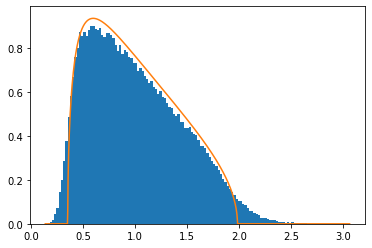

In [7]:
#con matrices chicas de 5 x 30

EE(randcv(5,30,50000), 5.0/30.)

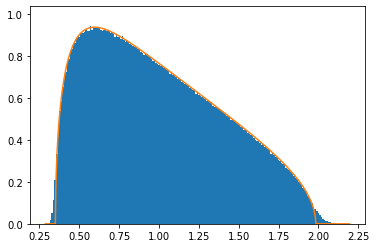

In [8]:
#con matrices grandes de 50 x 300 empieza a converger mejor

EE(randcv(50,300,50000), 5.0/30.)


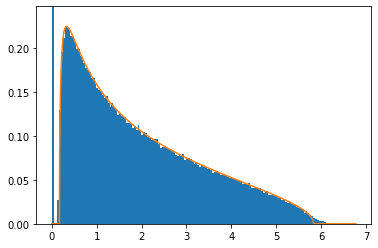

In [12]:
#con una lambda mayor a 1, hay muchos eigenvalores iguales a cero
EE(randcv(100,50,5000), 10./5)


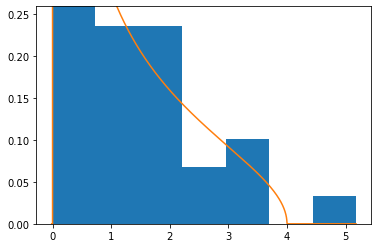

In [34]:
#prueba para separar ruido
kk=[]
for ii in range(1):
    s = np.random.randn(40,40)
    s = np.matmul(s,s.T)/s.shape[1]
    s = 0.99*s+0.01*(np.matmul(np.random.rand(40,40),np.random.rand(40,40).T))
    kk.append(s)
    
EE(kk, 1./1.)
#EE(randcv(5,30,5000), 5.0/30.)

# Encontrar ruido (sacado de https://medium.com/swlh/an-empirical-view-of-marchenko-pastur-theorem-1f564af5603d)

In [16]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity


def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [17]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

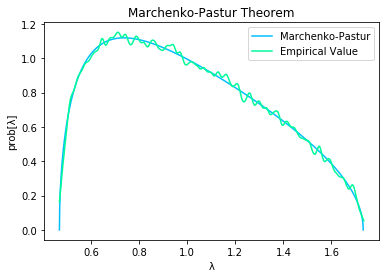

In [18]:
# Generating a random matrix
x = np.random.normal(size=(10000,1000))
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

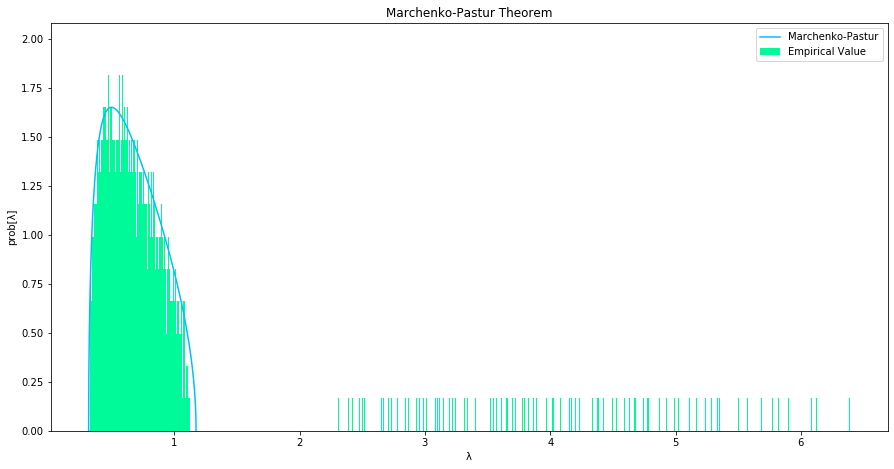

In [19]:
def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
        nCols (int): number of columns of random normal. This will be the dimensions of
            the output
        nFacts (int): number of rows of random normal
    Returns:
        np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov


def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
        cov (np.ndarray): covariance matrix
    Returns:
        np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr


def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
        var (float): Variance
        eVal (np.ndarray): Eigenvalues to fit.
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
        pts (int): Number of points used to construct the PDF
    Returns:
        float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse


def findMaxEval(eVal, q, bWidth):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e) everything else larger than
        this, is a signal eigenvalue
    Args:
        eVal (np.ndarray): Eigenvalues to fit on errPDFs
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
    Returns:
         (tuple): tuple containing:
            float: Maximum random eigenvalue
            float: Variance attributed to noise (1-result) is one way to measure
                signal-to-noise
    """

    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var
  
alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal
# Converting Covariancce to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)  # Empirical PDF

# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(15,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")


# Prueba para PCA con cosmología

C:\Users\52811\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  


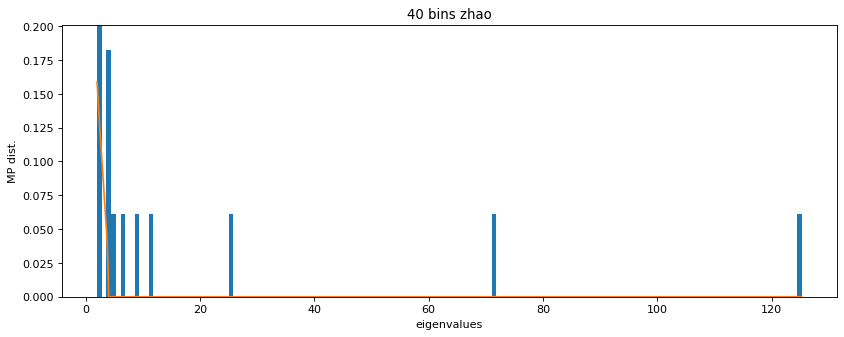

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import figure
figure(figsize=(16, 20), dpi=80)
%config Completer.use_jedi = False


def marchpast(l, g):
    "Distribucion Marchenko-Pastur"
    def m0(a):
        "Maximo en (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus  = (1+g**0.5)**2
    gminus = (1-g**0.5)**2
    return np.sqrt( m0(gplus-l)*m0(l-gminus) ) / (2*np.pi*g*l)


def EE(a, gamma):
    "Funcion pa los histogramas"
    ee, ev=np.linalg.eigh(a)
    nn, bb, patches=plt.hist(ee.ravel(), 
                                #bins="auto",
                                bins=150,
                                density=True)
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, gamma))
    plt.ylim(top=nn[1:].max() * 1.1)
    plt.ylabel(r"MP dist.")
    plt.xlabel("eigenvalues")
    fig = plt.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.title('40 bins zhao')
    plt.savefig('mp_eos_40bins_zhao.pdf')
    plt.show()

#la parte de PCA
n_pca = 40
n_erase = 3
type_graph = 'eos' # eos o rho

file_root = u'C:\\Users\\52811\\cosas_python\\SimpleMC-master\\chains_zhao_new\\'
#file_root += 'rho_tanh20_phy_rho_corr+Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'
file_root += 'eos_tanh20_phy_Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'
#file_root += 'eos_tanh40_phy_Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'


#las primeras 3 instrucciones son para borrar los de los otros 3 elementos de la matriz de los params que no nos importan
matriz_cov = np.loadtxt(file_root)
matriz_cov = np.matrix(matriz_cov)
matriz_cov = np.delete(np.delete(matriz_cov, range(n_erase),axis=1),range(n_erase),axis=0)

error = np.sqrt(np.diag(matriz_cov))
fisher = np.linalg.inv(matriz_cov)
fish_eig = np.linalg.eig(fisher)

d = np.diag(fish_eig[0])
w = np.transpose(fish_eig[1])
wt = fish_eig[1]

kk=[]
kk.append(d)
    
EE(kk, 1./1.)

C:\Users\52811\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
C:\Users\52811\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


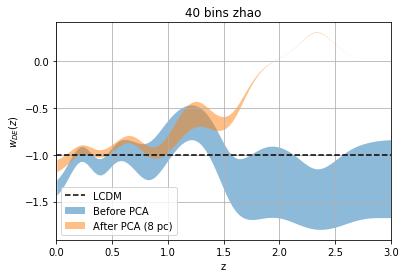

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

n_pca = 8
n_erase = 3
type_graph = 'eos' # eos o rho

file_root = u'C:\\Users\\52811\\cosas_python\\SimpleMC-master\\chains_zhao_new\\'
#file_root += 'rho_tanh20_phy_rho_corr+Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'
file_root += 'eos_tanh20_phy_eos_corr+Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'
#file_root += 'eos_tanh40_phy_Pantheon+CBAO+HD_nested_dynesty_multi_cov.txt'


#las primeras 3 instrucciones son para borrar los de los otros 3 elementos de la matriz de los params que no nos importan
matriz_cov = np.loadtxt(file_root)
matriz_cov = np.matrix(matriz_cov)
matriz_cov = np.delete(np.delete(matriz_cov, range(n_erase),axis=1),range(n_erase),axis=0)

error = np.sqrt(np.diag(matriz_cov))
fisher = np.linalg.inv(matriz_cov)
fish_eig = np.linalg.eig(fisher)

#n_pca -= n_erase
d = np.diag(fish_eig[0])
w = np.transpose(fish_eig[1])
wt = fish_eig[1]

#pt = [0.963,1.00,1.167,0.327,-0.199,-0.062] #rho_tanh6
#pt=[1.00, 0.906,1.021,0.649,0.9827,1.0031,0.7694,0.8574,0.9321,0.9531,0.8574,0.37493,0.22137,0.11638,-0.0045,-0.1894,-0.35155,-0.21086,-0.0903,0.01655,-0.01034] #rho_tanh20_rho_corr
pt=[-1.4583,-0.4294,-1.6647,-0.6989,-0.9571,-1.3108,-0.847,-0.6128,-0.5404,-0.8275,-1.5287,-1.3872,-1.2528,-1.2669,-1.3894,-1.5686,-1.4572,-1.3201,-1.2627,-1.2591] #eos_tanh20_eos_corr
#pt= [-1.5577,-0.3223,-1.7731,-0.6739,-0.8901,-1.5249,-0.7471,-0.6417,-0.5523,-0.7834,-1.6511,-1.2987,-1.2034,-1.2344,-1.3646,-1.6,-1.4456,-1.27,-1.2758,-1.2474] #eos_tanh20  
#pt =[-2.0966,-0.794,-0.5294,-0.7236,-1.434,-1.864,-0.9257,-0.6955,-0.7657,-1.2322,-1.4738,-1.3736,-1.2041,-1.0377,-0.9711,-0.9873,-0.9653,-0.9316,-1.0266,-1.2654,-1.5418,-1.7744,-1.6939,-1.7406,-1.7319,-1.7422,-1.7478,-1.7731,-1.7862,-1.8256,-1.8865,-1.886,-1.8654,-1.7989,-1.774,-1.7546,-1.7579,-1.7701,-1.7813,-1.7851]#eos_tanh40


z = np.linspace(0.01,3.0,len(pt))
pt = np.matrix(pt)
p = np.transpose(pt)
q = np.matmul(w,p)
sigma_squared_q = 1/(np.diag(d))
sigma_squared_q, q, w = zip(*sorted(zip(sigma_squared_q,q,w)))

wz = w[0]*np.asscalar(q[0])
for ii in range(n_pca-1):
    wz += w[ii+1]*np.asscalar(q[ii+1])

sigma_wz = (sigma_squared_q[0])*(np.array(w[0])[0]**2)
for ii in range(n_pca-1):
    sigma_wz += (sigma_squared_q[ii+1])*(np.array(w[ii+1])[0]**2)
sigma_wz = sigma_wz**0.5

def eos(z1,pt1):
    w_i = pt1
    z_i = np.linspace(0.01,3.0,len(w_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    w=w_i[0]
    for jj in range(len(w_i)-1):
        w+=bines(w_i[jj+1],w_i[jj],z1,z_i[jj+1],0.15)
    return w

z = np.linspace(0.01,3.0,100)

plt.rc('font', size=10)
if type_graph=='rho':
    plt.fill_between(z, 0.7*eos(z,np.array(pt)[0]-0.7*error**2), 0.7*eos(z,np.array(pt)[0]+0.7*error**2), alpha=0.5, antialiased=True)
    plt.fill_between(z, 0.7*eos(z,np.array(wz)[0]-0.7*sigma_wz**2), 0.7*eos(z,np.array(wz)[0]+0.7*sigma_wz**2), alpha=0.5, antialiased=True)
    plt.grid(axis = 'both')
    plt.ylabel(r'$\rho_{DE}(z)/\rho_{c,0}$')
elif type_graph=='eos':    
    plt.fill_between(z, eos(z,np.array(pt)[0]-error**2), eos(z,np.array(pt)[0]+error**2), alpha=0.5, antialiased=True)
    plt.fill_between(z, eos(z,np.array(wz)[0]-sigma_wz**2), eos(z,np.array(wz)[0]+sigma_wz**2), alpha=0.5, antialiased=True)
    plt.grid(axis = 'both')
    plt.ylabel(r'$w_{DE}(z)$')
plt.xlabel('z')

z_lcdm = np.linspace(0,3,100)
lcdm = np.empty(100)
if type_graph=='eos':
    lcdm.fill(-1)
elif type_graph=='rho':
    lcdm.fill(0.7)
plt.plot(z_lcdm,lcdm, linestyle='--', color='k')

plt.xlim(0.0,3.0)
plt.legend(('LCDM','Before PCA','After PCA ('+str(n_pca)+' pc)'),loc='lower left')
plt.title('40 bins zhao')
plt.savefig('mppca_eos_20bins_zhao.pdf')

In [11]:
print(d)

[[116.5594751    0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          69.23801724   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          24.8380543    0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          11.30717772   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0. 

In [30]:
print(w[0].reshape(20))

[[-0.21347012 -0.70150099 -0.63165089 -0.23082837  0.02831222  0.04884607
   0.03609342  0.02549739  0.03549816  0.04401791  0.03373763  0.01142545
   0.00137982  0.00147737  0.00373525  0.01762101  0.01027886  0.00411213
  -0.00133379 -0.00160116]]


In [38]:
test =np.array(w[18])
print((test**2))

[[1.02665701e-04 1.60879198e-04 1.06372263e-04 1.19778556e-05
  2.17454123e-05 1.29026004e-04 5.58485068e-05 2.77615500e-06
  4.68979086e-05 4.58568784e-05 5.51403659e-04 2.50788689e-03
  7.68413788e-04 1.97436899e-03 2.69448736e-02 2.76079545e-03
  1.28809021e-02 1.63396002e-01 3.80655890e-01 4.06875418e-01]]


In [11]:
abs(wt)

matrix([[2.13470120e-01, 3.12975175e-01, 5.11328125e-01, 6.14858791e-01,
         2.57411158e-01, 2.60373288e-01, 1.24856888e-01, 5.78163147e-02,
         2.12558420e-01, 1.03852803e-01, 8.42226214e-03, 1.01324085e-02,
         1.93352936e-02, 2.02986842e-02, 4.86955511e-02, 4.91288974e-02,
         3.67019310e-02, 1.76093674e-02, 1.59274139e-02, 1.89961817e-02],
        [7.01500994e-01, 2.53090267e-01, 3.18857017e-01, 2.82276327e-01,
         9.75105963e-02, 3.28403134e-01, 1.68347684e-01, 3.39843903e-02,
         2.89399453e-01, 9.90490974e-02, 1.64245078e-02, 1.26838164e-02,
         1.51538684e-02, 3.17326126e-02, 8.52135675e-02, 9.36904729e-02,
         5.18153669e-02, 2.78096877e-02, 2.63159706e-02, 1.48029382e-02],
        [6.31650888e-01, 1.69888627e-01, 4.44968613e-01, 1.45453881e-01,
         4.12655896e-02, 3.49783565e-01, 1.87072999e-01, 2.69222685e-02,
         3.47834284e-01, 1.60458853e-01, 2.13851702e-02, 1.03136930e-02,
         1.75108114e-02, 4.47905618e-02, 1.131980

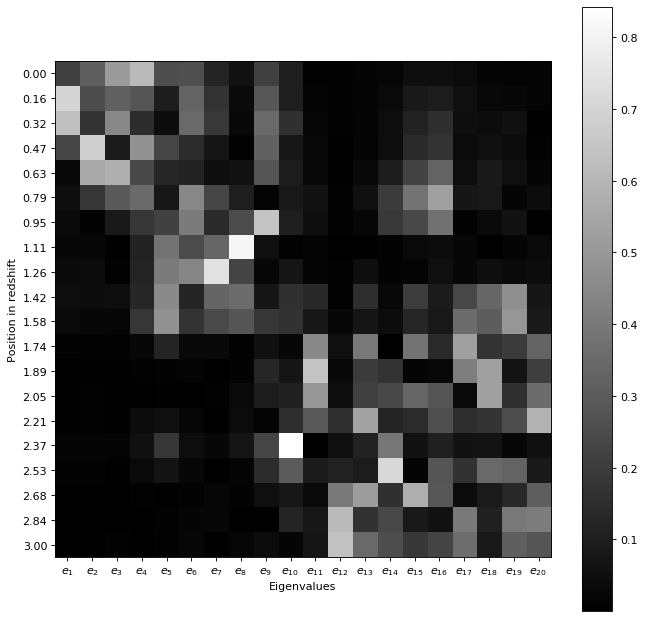

In [6]:
from matplotlib.pyplot import figure

n_bins = 20
position=np.linspace(0.0,3.0,n_bins)
figure(figsize=(10, 10), dpi=80)

l=[]
zbin=[]
eigz=[]
for ii in range(n_bins):
    l+=[ii]
    #zbin+=[r'$z_{%d}$'%(ii+1)]
    eigz+=[r'$e_{%d}$'%(ii+1)]
    zbin+=[r'%.2f'%position[ii]]
    

plt.imshow(abs(wt), cmap='gray')
plt.xticks(ticks=l,labels=eigz)
plt.xlabel(r'Eigenvalues')
plt.yticks(ticks=l,labels=zbin)
plt.ylabel(r'Position in redshift')
plt.colorbar()
plt.savefig('eig_vec_fig_20bins.pdf')